### Anime.csv
- `anime_id` - unique id identifying an anime;
- `name` - full name of anime;
- `genre` - comma separated list of genres for this anime;
- `type` - movie, TV, OVA, etc;
- `episodes` - how many episodes in this show. (1 if movie);
- `rating` - average rating out of 10 for this anime;
- `members` - number of community members that are in this anime's
"group".

In [335]:
import pandas as pd

df_anime = pd.read_csv('anime.csv')
df_rating = pd.read_csv('rating.csv')

In [336]:
# explode from str of genre to list and rename some columns
df_anime = (
    df_anime
        .rename(columns={'genre': 'genres', 'rating': 'avg_rating'})
        .assign(genres=lambda x: 
            x['genres'].str.replace(' ', '').str.split(','))
        .assign(episodes=lambda df:
            df['episodes'].replace('Unknown', -1).astype(int)
        )
)

df_anime.head()

,anime_id,name,genres,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266


In [337]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anime_id    12294 non-null  int64  
 1   name        12294 non-null  object 
 2   genres      12232 non-null  object 
 3   type        12269 non-null  object 
 4   episodes    12294 non-null  int32  
 5   avg_rating  12064 non-null  float64
 6   members     12294 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 624.4+ KB


### Rating.csv
- `user_id` - non-identifiable randomly generated user id;
- `anime_id` - the anime that this user has rated;
- `rating` - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [338]:
# delete useless rows
df_rating = df_rating[df_rating['rating'] != -1].sort_index()

df_rating.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [339]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6337241 entries, 47 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 193.4 MB


## Статистический анализ

In [364]:
fwe = df_anime['episodes'] != -1 # filter with episodes
fwg = ~df_anime['genres'].isna()         # filter with genre
fwt = ~df_anime['type'].isna()          # filter with type
fwr = ~df_anime['avg_rating'].isna()        # filter with rating

In [341]:
genres = (
    df_anime[fwg & fwr]['genres']
        .explode()
        .unique()
)
df_anime_exploded = (
    df_anime[fwg & fwr]
        .explode('genres')
        .reset_index(drop=True)
)

print(f'Found {len(genres)} type of genre: \n{genres}')
df_anime_exploded.head()

Found 43 type of genre: 
['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'SuperPower' 'Space' 'SliceofLife' 'Mecha'
 'Music' 'Mystery' 'Seinen' 'MartialArts' 'Vampire' 'Shoujo' 'Horror'
 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'ShounenAi' 'Game'
 'Dementia' 'Harem' 'Cars' 'Kids' 'ShoujoAi' 'Hentai' 'Yaoi' 'Yuri']


,anime_id,name,genres,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,Drama,Movie,1,9.37,200630
1,32281,Kimi no Na wa.,Romance,Movie,1,9.37,200630
2,32281,Kimi no Na wa.,School,Movie,1,9.37,200630
3,32281,Kimi no Na wa.,Supernatural,Movie,1,9.37,200630
4,5114,Fullmetal Alchemist: Brotherhood,Action,TV,64,9.26,793665


In [342]:
# Rating anime grouped by genre
df_anime_group_genre = (
    df_anime_exploded
        .groupby(['genres'])
        .agg(average_rating=('avg_rating', 'mean'),
             max_rating=('avg_rating', 'max'),
             min_rating=('avg_rating', 'min'),
             count=('avg_rating', 'count'))
        .assign(average_rating = lambda x: round(x.average_rating, 3))
        .sort_values('average_rating', ascending=False)
)
df_anime_group_genre.head()

,average_rating,max_rating,min_rating,count
genres,,,,
Josei,7.443,8.59,5.47,52
Thriller,7.382,9.17,3.74,86
Mystery,7.232,8.88,3.63,485
Police,7.122,8.72,4.12,195
Shounen,7.058,9.26,3.11,1684


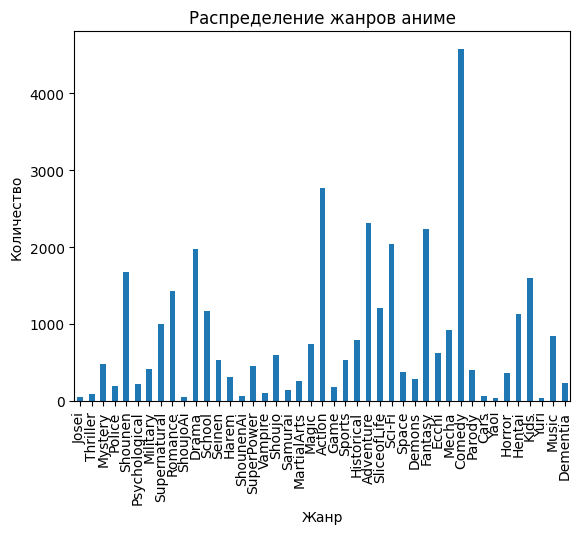

In [343]:
import matplotlib.pyplot as plt

df_anime_group_genre['count'].plot(kind='bar')
plt.title('Распределение жанров аниме')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.show()

In [344]:
df_merged = pd.merge(df_anime[fwr], df_rating, on='anime_id', how='inner')

# Count rating anime grouped by name from rating.csv
(
    df_merged
        .groupby('name')
        .agg(count=('anime_id', 'count'))
        .sort_values(by='count', ascending=False)
).head()


,count
name,
Death Note,34226
Sword Art Online,26310
Shingeki no Kyojin,25290
Code Geass: Hangyaku no Lelouch,24126
Angel Beats!,23565


In [345]:
# Top high rated anime from rating.csv
df_top_rating = (
    df_merged
    .groupby(['name'])
    .agg(sum_rating=('rating', 'sum'),
         count_rating=('rating', 'count'))
    .assign(calculated_rating = lambda df: round(df.sum_rating / df.count_rating, 2))
    .query('count_rating > 10')
    .drop(['sum_rating', 'count_rating'], axis=1)
    .sort_values('calculated_rating', ascending=False)
)
df_top_rating.head()

,calculated_rating
name,
Gintama°,9.45
Kimi no Na wa.,9.43
Ginga Eiyuu Densetsu,9.39
Fullmetal Alchemist: Brotherhood,9.32
Gintama&#039;,9.27


In [346]:
df_top_anime = df_anime[fwr][['name', 'avg_rating']]

df_merged_rating = (
    pd.merge(df_top_rating, df_top_anime, on='name', how='inner')
        .assign(loss = lambda df: abs(df['calculated_rating'] - df['avg_rating']))
        .sort_values('loss', ascending=False)
        .reset_index(drop=True)
)
df_merged_rating.head()

,name,calculated_rating,avg_rating,loss
0,Crayon Shin-chan Movie 16: Chou Arashi wo Yobu...,8.21,6.77,1.44
1,Kago Shintarou Anime Sakuhin Shuu,6.59,5.23,1.36
2,Duel Masters Zero,5.07,6.40,1.33
3,Red Colored Bridge,2.64,3.90,1.26
4,Ana no Oku no Ii Tokoro,7.60,6.35,1.25


In [347]:
print(f'Mean loss of rating {df_merged_rating.loss.mean() :.5f}')

Mean loss of rating 0.19531


## Построение моделей

In [348]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [349]:
df = df_anime[fwr & fwg & fwe].reset_index(drop=True)
df.head()

,anime_id,name,genres,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266


In [350]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12017 entries, 0 to 12016
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anime_id    12017 non-null  int64  
 1   name        12017 non-null  object 
 2   genres      12017 non-null  object 
 3   type        12017 non-null  object 
 4   episodes    12017 non-null  int32  
 5   avg_rating  12017 non-null  float64
 6   members     12017 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 610.4+ KB


Оценка корреляции между количеством эпизодов и рейтингом

Корреляционный коэффициент Пирсона: 0.08880
Полученное значение указывает на слабую положительную корреляцию между количеством серий и рейтингом



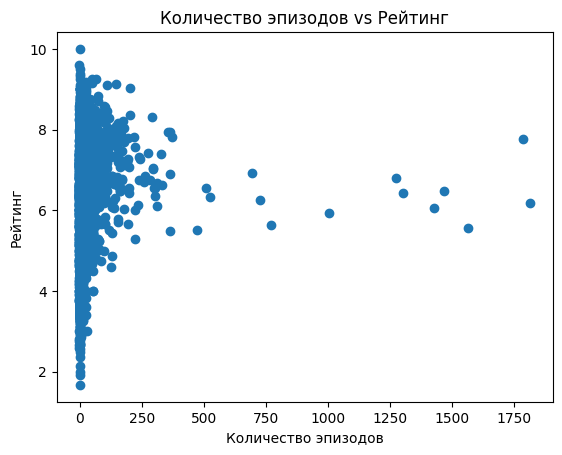

In [351]:
correlation = df[['episodes', 'avg_rating']].corr().iloc[0, 1]
print(f'Корреляционный коэффициент Пирсона: {correlation:.5f}\n'
      f'Полученное значение указывает на слабую положительную корреляцию между количеством серий и рейтингом\n')


# Диаграмма рассеяния
plt.scatter(df['episodes'], df['avg_rating'])
plt.title('Количество эпизодов vs Рейтинг')
plt.xlabel('Количество эпизодов')
plt.ylabel('Рейтинг')
plt.show()

Линейная регрессия

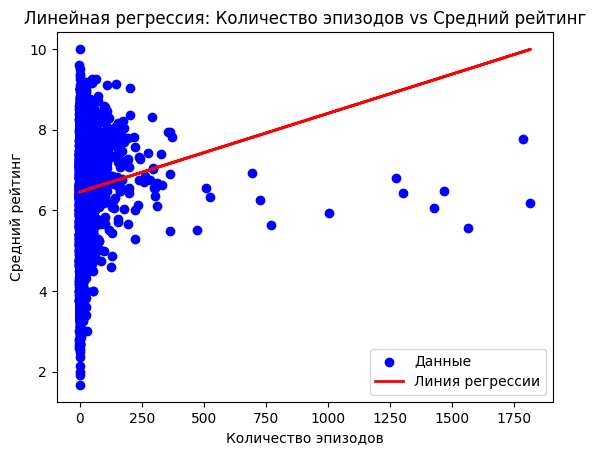

In [352]:
# Linear regression
X = df[['episodes']]
y = df['avg_rating']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.scatter(df['episodes'], df['avg_rating'], color='blue', label='Данные')
plt.plot(df['episodes'], y_pred, color='red', linewidth=2, label='Линия регрессии')
plt.title('Линейная регрессия: Количество эпизодов vs Средний рейтинг')
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний рейтинг')
plt.legend()
plt.show()

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = model.predict(X_test)

# Метрики оценки
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Средняя квадратичная ошибка: {mse}')
print(f'Коэффициент детерминации: {r2}')

Средняя квадратичная ошибка: 1.0327794507628905
Коэффициент детерминации: 0.011364877654687078


Кластеризация

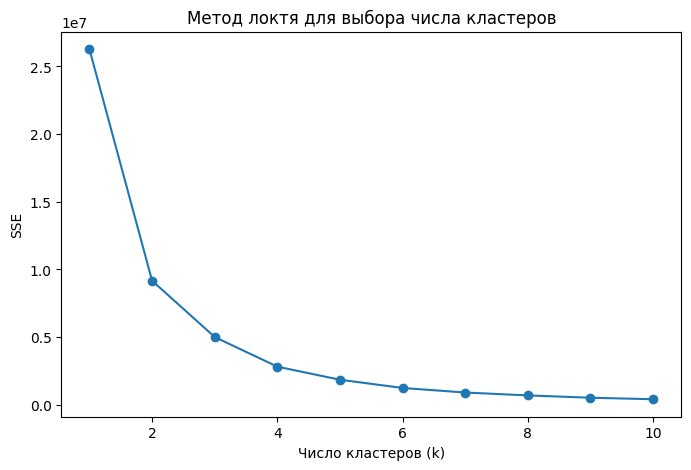

In [354]:
# Список для хранения значений SSE
sse = []

# Попробуйте разные числа кластеров
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Постройте график для визуализации
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Метод локтя для выбора числа кластеров')
plt.xlabel('Число кластеров (k)')
plt.ylabel('SSE')
plt.show()

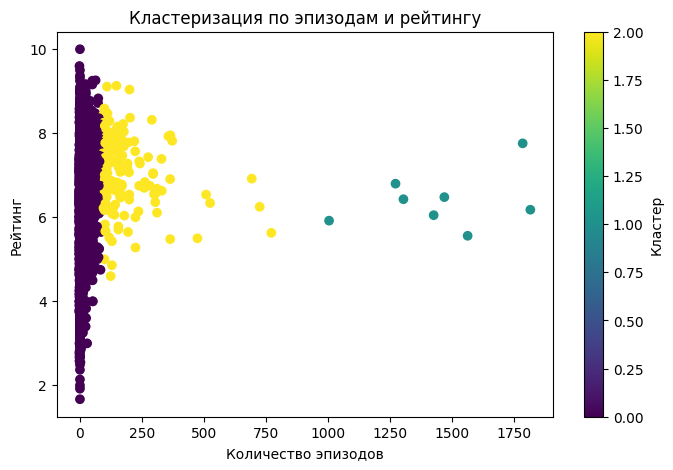

In [355]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Визуализация кластеров
plt.figure(figsize=(8, 5))
plt.scatter(df['episodes'], df['avg_rating'], c=df['cluster'], cmap='viridis', marker='o')
plt.title('Кластеризация по эпизодам и рейтингу')
plt.xlabel('Количество эпизодов')
plt.ylabel('Рейтинг')
plt.colorbar(label='Кластер')
plt.show()

Анализ распределения

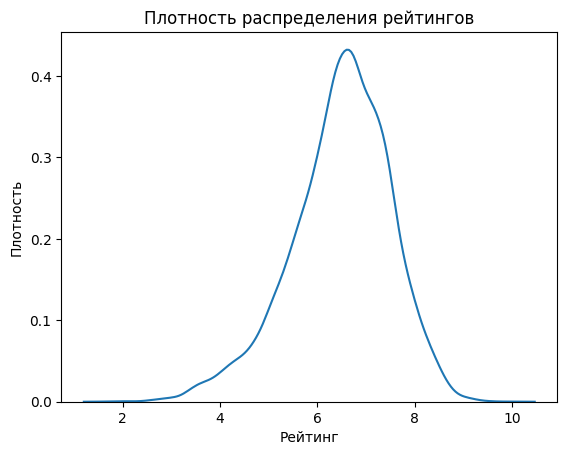

In [356]:
sns.kdeplot(df['avg_rating'])
plt.title('Плотность распределения рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Плотность')
plt.show()

In [360]:
stat, p_value = stats.shapiro(df['avg_rating'])
print(f'Statistic: {stat}, p-value: {p_value}')
if p_value > 0.05:
    print('Распределение нормально')
else:
    print('Распределение не нормально')

Statistic: 0.9833153486251831, p-value: 3.824706485845143e-35
Распределение не нормально


Выбросы

In [375]:
z_scores = np.abs(stats.zscore(df[['episodes', 'avg_rating']]))
df_no_outliers = df[~(z_scores < 3).all(axis=1)].sort_values(by='episodes', ascending=False)
df_no_outliers.head()

,anime_id,name,genres,type,episodes,avg_rating,members,cluster
6293,12393,Oyako Club,"[Comedy, SliceofLife]",TV,1818,6.18,160,1
929,2471,Doraemon (1979),"[Adventure, Comedy, Fantasy, Kids, Sci-Fi, Sho...",TV,1787,7.76,14233,1
9207,23349,Kirin Monoshiri Yakata,[Kids],TV,1565,5.56,116,1
5358,6277,Manga Nippon Mukashibanashi (1976),"[Fantasy, Historical]",TV,1471,6.48,406,1
6577,8213,Hoka Hoka Kazoku,[Comedy],TV,1428,6.05,194,1


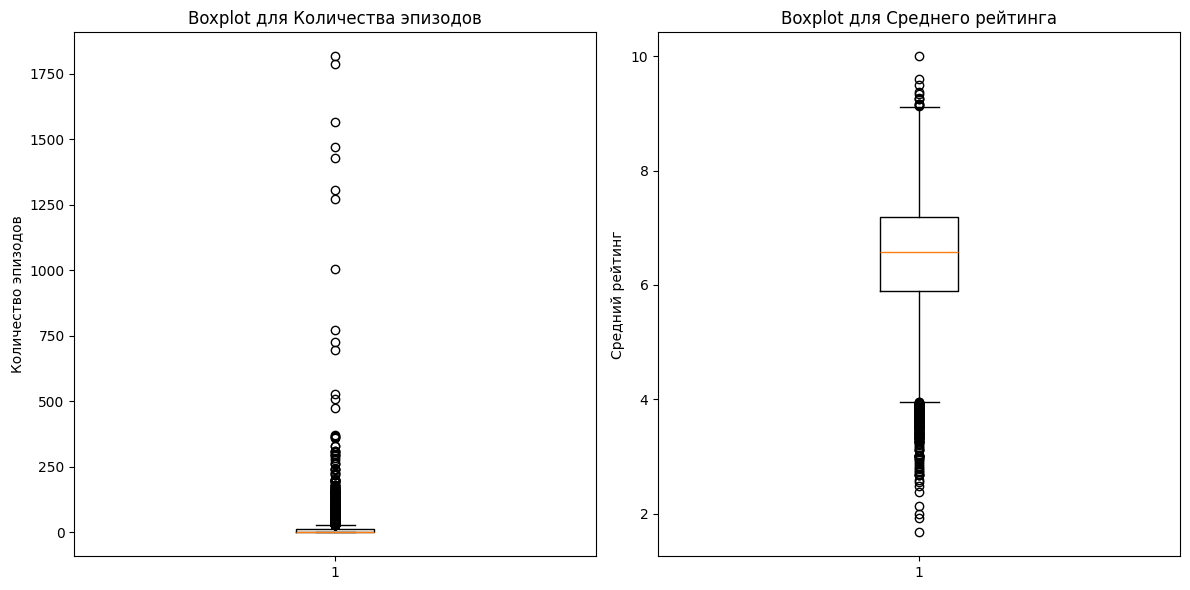

In [358]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(df['episodes'])
plt.title('Boxplot для Количества эпизодов')
plt.ylabel('Количество эпизодов')

plt.subplot(1, 2, 2)
plt.boxplot(df['avg_rating'])
plt.title('Boxplot для Среднего рейтинга')
plt.ylabel('Средний рейтинг')

plt.tight_layout()
plt.show()